In [1]:
from typing import NamedTuple, Any
import sympy as sym
from sympy.utilities.lambdify import lambdastr
import numpy as np
import numpy.typing as npt
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import display, Markdown
from scipy import integrate
from scipy.integrate import solve_bvp, solve_ivp
from scipy.optimize import curve_fit
from scipy.special import jv
from scipy import optimize
from collections.abc import Callable, Iterable, Iterator
from module_initialize import *
from functools import partial
from concurrent import futures
from tqdm.notebook import tqdm
from itertools import pairwise, product
from contextlib import nullcontext

In [2]:
def create_experiment(main_wave: bool, oblique_wave: bool, shear_flow: bool):
    POF = module_POF(main_wave = main_wave, oblique_wave = oblique_wave, shear_flow = shear_flow)
    members = (attr for attr in dir(POF) if not callable(getattr(POF, attr)) and not (attr.startswith("__") or attr.startswith("_")))
    methods = (attr for attr in dir(POF) if callable(getattr(POF, attr)) and not (attr.startswith("__") or attr.startswith("_")))

    for member in members if members else []:
        globals()[member] = getattr(POF, member)

    for method in methods if methods else []:
        globals()[method] = getattr(POF, method)
    
    del POF

    return bool(members) or bool(methods)

In [3]:
if_main_wave = True
if_oblique_wave = True
if_shear_flow = True
create_experiment(main_wave = if_main_wave, oblique_wave = if_oblique_wave, shear_flow = if_shear_flow)

True

In [4]:
def get_stokes_drift(verbose = False):

    # Us0
    verbose_print(verbose, 'Initial wave: ')
    verbose_display(verbose, sym.Eq(sym_phi0_symbol, sym_phi0))
    sym_u0x, sym_u0y, sym_u0z = (sym_phi0.diff(var) for var in (sym_x, sym_y, sym_z))

    sym_Us0x = (sym.I * sym_u0y / sym_omega * sym_u0x.conjugate()).diff(sym_y) + \
                (sym.I * sym_u0z / sym_omega * sym_u0x.conjugate()).diff(sym_z)
    sym_Us0x = sym_Us0x / 2
    sym_Us0y = 0
    sym_Us0x = sym_Us0x.subs(sym_psi0, - sym.I * sym_omega * sym_h0) #!!!!!!!!!
    sym_Us0x = sym_Us0x.simplify()
    
    verbose_display(verbose, sym.Eq(sym.Symbol(r'U^{s0}_x'), sym_Us0x))

    # dUs
    verbose_print(verbose, 'Oblique wave: ')
    verbose_display(verbose, sym.Eq(sym_dphi_symbol, sym_dphi))
    sym_dux, sym_duy, sym_duz = (sym_dphi.diff(var) for var in (sym_x, sym_y, sym_z))

    sym_dUsx = (sym.I * sym_duy / sym_omega * (sym_u0x).conjugate()).diff(sym_y) + \
                (sym.I * sym_duz / sym_omega * (sym_u0x).conjugate()).diff(sym_z) + \
                ((sym.I * sym_u0y / sym_omega).conjugate() * sym_dux).diff(sym_y) + \
                ((sym.I * sym_u0z / sym_omega).conjugate() * sym_dux).diff(sym_z)
    sym_dUsx = sym_dUsx / 2
    sym_dUsy = (sym.I * sym_dux / sym_omega * (sym_u0y).conjugate()).diff(sym_x) + \
                (sym.I * sym_duz / sym_omega * (sym_u0y).conjugate()).diff(sym_z) + \
                ((sym.I * sym_u0x / sym_omega).conjugate() * sym_duy).diff(sym_x) + \
                ((sym.I * sym_u0z / sym_omega).conjugate() * sym_duy).diff(sym_z)
    sym_dUsy = sym_dUsy / 2
    
    sym_dUsx = sym_dUsx.subs(sym_psi0, - sym.I * sym_omega * sym_h0)
    sym_dUsy = sym_dUsy.subs(sym_psi0, - sym.I * sym_omega * sym_h0)

    sym_dUsx = sym_dUsx.simplify()
    sym_dUsy = sym_dUsy.simplify()

    verbose_display(verbose, sym.Eq(sym.Symbol(r'\delta U^s_x'), sym_dUsx))
    verbose_display(verbose, sym.Eq(sym.Symbol(r'\delta U^s_y'), sym_dUsy))

    return (sym_Us0x, sym_Us0y, 0), (sym_alpha * sym_dUsx, sym_alpha * sym_dUsy, 0)


def get_vortex_force(verbose = False):

    sym_Us0_vec, sym_dUs_vec = get_stokes_drift(verbose = verbose)
     
    sym_vec_O0 = (0, sym_O0, 0)

    sym_dfV_1 = vector_mult(sym_Us0_vec, sym_vec_dO) 
    sym_dfV_2 = vector_mult(sym_dUs_vec, sym_vec_O0)

    sym_dfV = tuple(map(lambda x, y: x + y, sym_dfV_1, sym_dfV_2))
    sym_dfV = simplify_vector(sym_dfV)
    sym_curl_dfV = curl(sym_dfV)
    sym_curl_dfV = simplify_vector(sym_curl_dfV)

    verbose_display(verbose, sym.Eq(sym.Symbol(r'\delta{f^V}_x'), sym_dfV[0]))
    verbose_display(verbose, sym.Eq(sym.Symbol(r'\delta{f^V}_y'), sym_dfV[1]))
    verbose_display(verbose, sym.Eq(sym.Symbol(r'\delta{f^V}_z'), sym_dfV[2]))
    verbose_display(verbose, sym.Eq(sym.Symbol(r'\big(\operatorname{curl}\delta{f^V}\big)_x'), sym_curl_dfV[0]))
    verbose_display(verbose, sym.Eq(sym.Symbol(r'\big(\operatorname{curl}\delta{f^V}\big)_y'), sym_curl_dfV[1]))
    verbose_display(verbose, sym.Eq(sym.Symbol(r'\big(\operatorname{curl}\delta{f^V}\big)_z'), sym_curl_dfV[2]))

    return sym_dfV, sym_curl_dfV


def get_equation_dPsi(verbose = False):

    sym_dfV, sym_curl_dfV = get_vortex_force(verbose = verbose)
    sym_dfVx = sym_dfV[0]
    sym_curl_dfVx = sym_curl_dfV[0]

    laplas = lambda expr: expr.diff(sym_x, 2) + expr.diff(sym_y, 2) + expr.diff(sym_z, 2)

    sym_nu = 0

    # equation (38)
    sym_equation_dOx = (sym_lambda * sym_dOx - sym_nu * laplas(sym_dOx) + sym_V0_symbol * sym_dOx.diff(sym_x)) - \
                        sym_O0 * (sym_dOz + sym_dVx.diff(sym_y)) - sym_curl_dfVx
    sym_equation_dOx = sym_equation_dOx.simplify()

    # equation (39)
    sym_equation_dVx = (sym_lambda * sym_dVx - sym_nu * laplas(sym_dVx) + sym_V0_symbol * sym_dVx.diff(sym_x)) + \
                        sym_dVz * sym_O0 - sym_dfVx
    sym_equation_dVx = sym_equation_dVx.simplify()

    verbose_print(verbose, "Initial equations: ")
    verbose_display(verbose, sym.Eq(sym_equation_dVx, 0))
    verbose_display(verbose, sym.Eq(sym_equation_dOx, 0))

    sym_dVx_dVz_ratio = sym.solve(sym_equation_dVx, sym_dVx_symbol)[0]
    sym_dVy_to_dPsi = sym_dPsi.diff(sym_z)
    sym_dVz_to_dPsi = -sym.I * sym_theta * sym_dPsi
    sym_dVx_to_dPsi = sym_dVx_dVz_ratio.subs(sym_dVz_symbol, sym_dVz_to_dPsi)

    verbose_display(verbose, sym.Eq(sym_dVx_symbol, sym_dVx_to_dPsi))
    verbose_display(verbose, sym.Eq(sym_dVy_symbol, sym_dVy_to_dPsi))
    verbose_display(verbose, sym.Eq(sym_dVz_symbol, sym_dVz_to_dPsi))

    substitutions_dV_to_dPsi = ((sym_dVx_symbol, sym_dVx_to_dPsi), (sym_dVy_symbol, sym_dVy_to_dPsi), (sym_dVz_symbol, sym_dVz_to_dPsi))
    sym_equation_dPsi = substitute(sym_equation_dOx, substitutions_dV_to_dPsi)
    sym_equation_dPsi = sym_equation_dPsi.simplify()

    over_prefactor = sym.exp(-sym.I * sym_theta * sym_y - sym_lambda * sym_t)
    sym_equation_dPsi = sym_equation_dPsi * over_prefactor
    sym_equation_dPsi = sym_equation_dPsi.simplify()

    sym_equation_dPsi = sym_equation_dPsi.simplify().simplify()
    sym_equation_dPsi = simplify_eq_with_assumptions(sym.Eq(sym_equation_dPsi, 0)).lhs
    sym_equation_dPsi = sym_equation_dPsi.simplify()

    verbose_print(verbose, "Final equation: ")
    verbose_display(verbose, sym.Eq(sym_equation_dPsi, 0))

    return sym_equation_dPsi, substitutions_dV_to_dPsi


def get_main_equations(verbose = False, super_verbose: bool = False):
    # Getting dPsi equation
    sym_equation_dPsi, substitutions_dV_to_dPsi = get_equation_dPsi(verbose = super_verbose)

    # Create dimensionless dPsi equation
    verbose_display(verbose, 
                    Markdown(r'Dimensionless $\delta{\Psi}$ equation: ')
                    )
    sym_equation_dPsi = substitute(sym_equation_dPsi, substitutions_dimensionless).simplify().simplify()
    sym_d2z_dPsi_dim_expr = sym.solve(sym_equation_dPsi, sym_dPsi_dim.diff(sym_z, 2))[0]
    sym_d2z_dPsi_dim_expr = sym_d2z_dPsi_dim_expr.simplify()
    verbose_display(verbose, sym.Eq(sym_d2z_dPsi_dim_symbol, sym_d2z_dPsi_dim_expr))
    verbose_display(verbose, 
                    Markdown(r'$\delta{\Psi}$ equation in the limit $\epsilon \ll 1$: ')
                    )
    sym_d2z_dPsi_dim_expr = sym_d2z_dPsi_dim_expr.series(sym_epsilon, n = 2).removeO().simplify()
    verbose_display(verbose, sym.Eq(sym_d2z_dPsi_dim_symbol, sym_d2z_dPsi_dim_expr))

    # Creating substitutions dVz -> dPsi according to (55) from POF
    verbose_display(verbose, 
                Markdown(r'Local substitutions: ')
                )
    sym_dPsi_local_subsitution0 = sym_epsilon / sym_mu * sym_dpsi * sym_foo
    sym_mu_local_subsitution = sym.solve(sym.Eq(*substitutions_dimensionless.lambda_mu), sym_mu)[0]
    sym_epsilon_local_subsitution = sym.solve(sym.Eq(*substitutions_dimensionless.O0), sym_epsilon)[0]
    sym_dPsi_local_subsitution1 = sym_dPsi_local_subsitution0.subs({
                    sym_mu: sym_mu_local_subsitution,
                    sym_epsilon: sym_epsilon_local_subsitution
        }).simplify()
    sym_dPsi_local_subsitution = sym_dPsi_local_subsitution1.subs(sym_omega0, sym_omega).simplify()
    sym_dVz_local_subsitution = substitutions_dV_to_dPsi[2][1].subs(sym_dPsi, sym_dPsi_local_subsitution)
    verbose_display(verbose,
        sym.Eq(
            sym_dPsi, 
            sym.Eq(sym_dPsi_local_subsitution0, 
                   sym.Eq(
                       sym_dPsi_local_subsitution1, sym_dPsi_local_subsitution, evaluate = False), 
                   evaluate = False), 
        evaluate = False)
    )
    verbose_display(verbose, 
        sym.Eq(
            sym_dVz_symbol,
            sym.Eq(
                substitutions_dV_to_dPsi[2][1], sym_dVz_local_subsitution, evaluate = False), 
        evaluate = False)                
    )
    substitutions_dimensionless_local = (substitutions_dimensionless.dxi, 
                                         substitutions_dimensionless.dpsi, 
                                         substitutions_dimensionless.psi0)

    # Printing global dimensionless substitutions
    if verbose: print_substitutions(substitutions_dimensionless) 

    # First boundary condition
    verbose_display(verbose, 
                    Markdown(r'First bc $\big($ assume $\dfrac{\lambda}{\Omega^{0}} \ll 1$ $\big)$: ')
                    )

    sym_bc_1 = sym_bc_1_initial
    verbose_display(verbose, sym_bc_1)
    sym_bc_1 = sym_bc_1.subs(sym_dVz_symbol, sym_dVz_local_subsitution).simplify()
    sym_bc_1 = substitute(sym_bc_1, substitutions_dimensionless_local).simplify()
    sym_bc_1 = sym.expand(sym_bc_1 / sym_omega)
    verbose_display(verbose, sym_bc_1)
    sym_bc_1 = sym_bc_1.subs(sym_lambda / sym_omega, sym_zu).series(sym_zu, n = 1).removeO().simplify()
    sym_bc_1 = simplify_eq_with_assumptions(sym.Eq(sym_bc_1, 0)).lhs
    verbose_display(verbose, sym_bc_1)
    
    verbose_print(verbose)

    # Second boundary condition
    verbose_display(verbose, 
                Markdown(r'Second bc $\big($ assume $\dfrac{\lambda}{\Omega^{0}} \ll 1$ $\big)$: ')
                )
    sym_bc_2 = sym_bc_2_initial
    verbose_display(verbose, sym_bc_2)
    sym_bc_2 = sym_bc_2.subs(sym_dp_symbol, sym_dp)
    substitution_omega = sym_omega * (sym_omega + sym_O0)
    verbose_display(super_verbose, sym.Eq(sym_g, substitution_omega))
    sym_bc_2 = sym_bc_2.subs(sym_g, substitution_omega)
    sym_bc_2 = substitute(sym_bc_2, substitutions_dimensionless_local).simplify()
    sym_bc_2 = sym.expand(sym_bc_2 / sym_omega**2)
    verbose_display(verbose, sym_bc_2)
    sym_bc_2 = sym_bc_2.subs(sym_lambda / sym_omega, sym_zu).series(sym_zu, n = 1).removeO().simplify()
    sym_bc_2 = simplify_eq_with_assumptions(sym.Eq(sym_bc_2, 0)).lhs
    verbose_display(verbose, sym_bc_2)

    verbose_print(verbose)

    # mu equation (in terms F(mu))
    verbose_display(verbose, 
                    Markdown(r'$F(\mu)$ equation in the limit $\epsilon \ll 1$ '
                             r'and $\Omega^{(0)} \gg \big(\theta h^{(0)}\big)^2\omega$: ')
                    )
    if if_oblique_wave: 
        sym_bc_matrix = sym.linear_eq_to_matrix([sym_bc_1, sym_bc_2], [sym_dh_dim, sym_dpsi_dim])[0]
        sym_eq_mu = sym_bc_matrix.det()
        sym_eq_mu = sym_eq_mu.simplify()
        sym_eq_mu = simplify_eq_with_assumptions(sym.Eq(sym_eq_mu, 0)).lhs
        verbose_display(verbose, sym_eq_mu)

        sym_eq_mu_rhs = sym.solve(sym_eq_mu, sym_F_symbol)[0]
        sym_eq_mu = sym_F_symbol - sym_eq_mu_rhs
        verbose_display(verbose, sym_eq_mu)
        sym_eq_mu = substitute(sym_eq_mu, substitutions_dimensionless)
        sym_eq_mu = sym.expand(sym_eq_mu)
        verbose_display(super_verbose, sym_eq_mu)
        sym_eq_mu = sym_eq_mu.simplify()
        sym_eq_mu = simplify_eq_with_assumptions(sym.Eq(sym_eq_mu, 0))
        sym_eq_mu = sym_eq_mu.lhs
        verbose_display(verbose, sym_eq_mu)
    else:
        sym_eq_mu = None

    verbose_print(verbose)

    # F(mu) expression
    verbose_display(verbose, 
                Markdown(r'Getting $F(\mu)$: ')
                )
    sym_F_expr = sym_F_expr_initial
    verbose_display(verbose, sym.Eq(sym_F_symbol, sym_F_expr_initial))
    verbose_display(verbose, sym.Eq(sym_dp_int_symbol, sym_dp_int_initial))
    sym_dp_int = substitute(sym_dp_int_initial, substitutions_dV_to_dPsi).simplify()
    sym_F_expr = sym_F_expr.subs(sym_dp_int_symbol, sym_dp_int)
    sym_F_expr = substitute(sym_F_expr, substitutions_dV_to_dPsi).simplify()
    sym_F_expr = substitute(sym_F_expr, substitutions_dimensionless).simplify()
    sym_F_expr = sym_F_expr.simplify()
    sym_dp_int_dim = sym_F_expr.find(sym.Integral).pop()
    sym_F_expr = sym_F_expr.subs(sym_dp_int_dim, sym_dp_int_dim_symbol).simplify()
    verbose_display(verbose, sym.Eq(sym_F_symbol, sym_F_expr))
    verbose_display(verbose, sym.Eq(sym_dp_int_dim_symbol, sym_dp_int_dim))
    verbose_display(verbose, 
                Markdown(r'$F(\mu)$ expression in the limit $\epsilon \ll 1$ '
                         r'and $\Omega^{(0)} \gg \big(\theta h^{(0)}\big)^2\omega$: ')
                )
    sym_F_expr = sym.expand(sym_F_expr)
    verbose_display(super_verbose, sym.Eq(sym_F_symbol, sym_F_expr))
    sym_F_expr = sym_F_expr.series(sym_epsilon, n = 1).removeO()
    verbose_display(super_verbose, sym.Eq(sym_F_symbol, sym_F_expr))
    sym_F_expr = sym_F_expr.subs(sym_theta * sym_h0 / sym_epsilon, sym_zu)
    verbose_display(super_verbose, sym.Eq(sym_F_symbol, sym_F_expr))
    sym_F_expr = sym_F_expr.series(sym_zu, n = 1).removeO()
    sym_F_expr = sym_F_expr.simplify()
    verbose_display(verbose, sym.Eq(sym_F_symbol, sym_F_expr))
    int_expr, int_limits = sym_dp_int_dim.args
    int_expr = int_expr.subs(sym_d2z_dPsi_dim_symbol, sym_d2z_dPsi_dim_expr).simplify()
    sym_dp_int_dim = sym.Integral(int_expr, int_limits)
    verbose_display(verbose, sym.Eq(sym_dp_int_dim_symbol, sym_dp_int_dim))

    verbose_print(verbose)

    verbose_display(verbose, 
                Markdown(r'$\mu$-equation to solve: ')
    )

    sym_eq_mu = sym_eq_mu.subs(sym_F_symbol, sym_F_expr).simplify()
    sym_eq_mu = simplify_eq_with_assumptions(sym.Eq(sym_eq_mu, 0))
    verbose_display(verbose, sym_eq_mu)
    sym_eq_mu = sym_eq_mu.lhs
    # sym_eq_mu = (sym_eq_mu / sym_epsilon**2).simplify()
    # verbose_display(verbose, sym_eq_mu)

    return sym_d2z_dPsi_dim_expr, sym_eq_mu, sym_dp_int_dim

In [5]:
sym_equations = get_main_equations(verbose = False, super_verbose = False)

In [6]:
def refactor_sym_equation(sym_equations: tuple, *, verbose: bool = False) -> tuple:
    sym_d2z_dPsi_dim_expr, sym_eq_mu, sym_dp_int_dim = sym_equations

    sym_eq_mu = sym_eq_mu.series(sym_theta, n = 1).removeO().simplify()
    sym_eq_mu = simplify_eq_with_assumptions(sym.Eq(sym_eq_mu, 0)).lhs

    sym_d2z_dPsi_dim_expr = sym_d2z_dPsi_dim_expr.replace(sym.sqrt(sym_theta**2 + 1), 1)

    expr, limits = sym_dp_int_dim.args
    expr = expr.series(sym_theta, n = 1).removeO().simplify()
    sym_dp_int_dim = sym.Integral(expr, limits)
    
    verbose_display(verbose, sym_d2z_dPsi_dim_expr)
    verbose_display(verbose, sym_eq_mu)
    verbose_display(verbose, sym_dp_int_dim)
    return sym_d2z_dPsi_dim_expr, sym_eq_mu, sym_dp_int_dim

sym_equations_refactored = refactor_sym_equation(sym_equations, verbose = False)

In [15]:
RealNumpyArray = NDArray[np.float64]


class NumericalParameters(NamedTuple):
    h0: float
    epsilon: float


class NumericalSolution(NamedTuple):
    num_mu: float
    theta: float
    alpha: float
    z: RealNumpyArray
    dPsi: RealNumpyArray
    partial_dPsi0: float


class MetaData(NamedTuple):
    num_mu_zero: float
    num_mu_singular: float
    partial_dPsi0: float
    theta: float
    alpha: float


class _MetaData(NamedTuple):
    num_mu: float
    theta: float
    alpha: float
    partial_dPsi0: float


class NumericalProblem:
    global sym_h0, sym_epsilon, sym_theta, sym_mu, sym_dPsi_dim, sym_dp_int_dim_symbol, sym_d2z_dPsi_dim_symbol
    __MAXITER: int = int(1e2)

    def __init__(self, sym_equations: tuple, 
                 numerical_parameters: NumericalParameters, 
                 N_POINTS: int = int(2**15)) -> None:    
        
        if not numerical_parameters.epsilon > numerical_parameters.h0**2:
            raise ValueError('Wrong initial parameters: epsilon must be greater then h0^2.')
        
        self.substitutions_numerical = (
            (sym_h0, numerical_parameters.h0),
            (sym_epsilon, numerical_parameters.epsilon),
            )
        self.__N_POINTS: int = N_POINTS
        self.__sym_equations = sym_equations
        self.equation_dPsi, self.num_eq_mu, self.num_dp_int_dim = self._lambdify_sym_equations(sym_equations)
        self.solution: NumericalSolution = None

    def show_equations(self) -> None:
        sym_d2z_dPsi_dim_expr, sym_eq_mu, sym_dp_int_dim = self.__sym_equations

        print('Solving the following system: ')
        display(sym.Eq(sym_d2z_dPsi_dim_symbol, sym_d2z_dPsi_dim_expr))
        display(sym.Eq(sym_eq_mu, 0))
        display(sym.Eq(sym_dp_int_dim_symbol, sym_dp_int_dim))

    def _lambdify_sym_equations(self, 
                                sym_equations) -> tuple[Callable[..., float], Callable[..., float], Callable[..., float]]:
        
        sym_d2z_dPsi_dim_expr, sym_eq_mu, sym_dp_int_dim = sym_equations

        # Lambdify equation dPsi
        sym_d2z_dPsi_dim_expr = substitute(sym_d2z_dPsi_dim_expr, self.substitutions_numerical).simplify()
        num_d2z_dPsi_dim = sym.lambdify([sym_mu, 
                                         sym_theta,
                                         sym_alpha,
                                         sym_z, 
                                         sym_dPsi_dim], 
                                         sym_d2z_dPsi_dim_expr, modules = 'numpy')
        
        equation_dPsi = lambda num_mu, theta, alpha, z, y: np.array((y[1], num_d2z_dPsi_dim(num_mu, theta, alpha, z, y[0])))
        
        # Lambdify dp_dim integral
        sym_dp_int_dim_expr = sym_dp_int_dim.args[0]
        sym_dp_int_dim_expr = substitute(sym_dp_int_dim_expr, self.substitutions_numerical)
        num_dp_int_dim_expr = sym.lambdify([sym_mu,
                                            sym_theta,
                                            sym_alpha, 
                                            sym_z, 
                                            sym_dPsi_dim], 
                                            sym_dp_int_dim_expr, modules = 'numpy')
        
        num_dp_int_dim = lambda num_mu, theta, alpha, z, dPsi: integrate.simpson(num_dp_int_dim_expr(num_mu, theta, alpha, z, dPsi), -z)

        # Lambdify base mu equation
        sym_eq_mu = substitute(sym_eq_mu, self.substitutions_numerical).simplify()
        sym_eq_mu = sym_eq_mu.subs(sym_dPsi_dim.diff(sym_z), sym_zu)
        num_eq_mu_lmd = sym.lambdify([sym_mu,
                                  sym_theta,
                                  sym_alpha,
                                  sym_zu,
                                  sym_dp_int_dim_symbol],
                                  sym_eq_mu, modules = 'numpy')
        
        num_eq_mu = lambda num_mu, theta, alpha, partial_dPsi0, num_dp_int: num_eq_mu_lmd(num_mu, theta, alpha, partial_dPsi0, num_dp_int)

        return equation_dPsi, num_eq_mu, num_dp_int_dim  

    def mu_problem(self, 
                   x: float, 
                   theta: float, 
                   alpha: float, 
                   partial_dPsi0_initial: float) -> float:
        
        # print(f'\tCalling mu equation with mu = {x:.3e}')
        z, dPsi, partial_dPsi0 = self.solve_dPsi_eq(x, theta, alpha, partial_dPsi0_initial)
        dp_int = self.num_dp_int_dim(x, theta, alpha, z, dPsi)
        return self.num_eq_mu(x, theta, alpha, partial_dPsi0, dp_int)

    def estimate_partial_dPsi0(self, 
                               num_mu: float, 
                               theta: float, 
                               alpha: float, 
                               CL2: bool = False) -> float:
        substitutions_numerical_local = (
            (sym_theta, theta),
            (sym_alpha, alpha),
            (sym_mu, num_mu),
            (sym_z, 0)
        )  

        if CL2:
            sym_dPsi_dim_CL2 = sym.besseli(sym_theta, sym_mu * sym.exp(sym_z))
            tmp = substitute(sym_dPsi_dim_CL2.diff(sym_z).simplify(), self.substitutions_numerical)
        else:
            global sym_dPsi_dim_est
            tmp = substitute(sym_dPsi_dim_est.diff(sym_z).simplify(), self.substitutions_numerical)
        
        partial_dPsi0_est = substitute(tmp, substitutions_numerical_local)
        return float(partial_dPsi0_est)
    
    def _shooting_method(self, 
                         num_mu: float, 
                         partial_dPsi0: float, 
                         equation_dPsi_metadata) -> tuple[RealNumpyArray, RealNumpyArray]:
        
        z, equation_dPsi_to_solve = equation_dPsi_metadata
        z_span = (z[0], z[-1])
        dPsi0, partial_dPsi0 = 0, partial_dPsi0
        y0 = [dPsi0, partial_dPsi0]
        solution = solve_ivp(lambda z, y: equation_dPsi_to_solve(num_mu, z, y), 
                             z_span, y0, t_eval = z, 
                             method = 'RK45', 
                             atol = 1e-18, 
                             rtol = 1e-13)
        dPsi = solution.y[0]
        return z, dPsi
    
    def _calculate_partial_dPsi0_newton(self, 
                                 num_mu: float, 
                                 partial_dPsi0_initial: float, 
                                 equation_dPsi_metadata) -> float:
        
        partial_dPsi0_problem = lambda x: self._shooting_method(num_mu, x, equation_dPsi_metadata)[1][-1]
        partial_dPsi0 = optimize.newton(func = partial_dPsi0_problem, 
                                        x0 = partial_dPsi0_initial,
                                        tol = 1e-14,
                                        maxiter = self.__MAXITER)
        return partial_dPsi0
    
    def _calculate_partial_dPsi0(self, 
                                 num_mu: float, 
                                 partial_dPsi0_initial: float, 
                                 equation_dPsi_metadata) -> float:
        
        # a = dPsi[z = inf] if partial_dPsi[z = 0] = 0
        # a + b = dPsi[z = inf] if partial_dPsi[z = 0] = 1 => b = dPsi[z = inf, 1] - dPsi[z = inf, 0]
        # a + b * partial_dPsi[z = 0] = 0 =>
        # => partial_dPsi[z = 0] = -a / b = -dPsi[z = inf, 0] / (dPsi[z = inf, 1] - dPsi[z = inf, 0])
        
        dPsi_inf_if_partial_dPsi_0 = self._shooting_method(num_mu, 0, equation_dPsi_metadata)[1][-1]
        dPsi_inf_if_partial_dPsi_1 = self._shooting_method(num_mu, 1, equation_dPsi_metadata)[1][-1]

        partial_dPsi0 = -dPsi_inf_if_partial_dPsi_0 / (dPsi_inf_if_partial_dPsi_1 - dPsi_inf_if_partial_dPsi_0)
       
        return partial_dPsi0
    
    def _create_equation_dPsi_metadata(self, 
                                       theta: float,
                                       alpha: float) -> tuple[RealNumpyArray, Callable]:
        
        equation_dPsi_to_solve = lambda num_mu, z, dPsi: self.equation_dPsi(num_mu, theta, alpha, z, dPsi)
        MAX_z = -3 / theta
        z = np.linspace(0, MAX_z, self.__N_POINTS, dtype = float)
        return z, equation_dPsi_to_solve

    def solve_dPsi_eq(self, 
                      num_mu: float, 
                      theta: float, 
                      alpha: float, 
                      partial_dPsi0_initial: float) -> tuple[RealNumpyArray, RealNumpyArray, float]:

        equation_dPsi_metadata = self._create_equation_dPsi_metadata(theta, alpha)

        partial_dPsi0 = self._calculate_partial_dPsi0(num_mu, partial_dPsi0_initial, equation_dPsi_metadata)
        z, dPsi = self._shooting_method(num_mu, partial_dPsi0, equation_dPsi_metadata)
        return z, dPsi, partial_dPsi0
    
    def solve_mu_eq_newton(self, 
                           num_mu_initial: float,
                           theta: float,
                           alpha: float,
                           partial_dPsi0_initial: float | None = None) -> NumericalSolution:
        
        if not partial_dPsi0_initial:
            partial_dPsi0_initial = self.estimate_partial_dPsi0(num_mu_initial, theta, alpha)
        
        num_mu = optimize.newton(func = self.mu_problem, 
                                 x0 = num_mu_initial, 
                                 args = (theta, alpha, partial_dPsi0_initial),
                                 tol = 1e-14,
                                 maxiter = self.__MAXITER)
        z, dPsi, partial_dPsi0 = self.solve_dPsi_eq(num_mu, theta, alpha, partial_dPsi0_initial)
        return NumericalSolution(num_mu, theta, alpha, z, dPsi, partial_dPsi0)  
    
    @classmethod
    def calculate_fields(cls, 
                         num_mu: float, 
                         theta: float, 
                         z: RealNumpyArray, 
                         dPsi: RealNumpyArray) -> tuple[RealNumpyArray, RealNumpyArray, RealNumpyArray]:
        
        partial_z = lambda field, z: np.diff(field) / np.diff(z)

        dVy = partial_z(dPsi, z)
        dVz = theta * dPsi
        dOx = num_mu**2 * np.exp(2 * z) * dPsi - np.exp(2 * z)

        return dVy, dVz, dOx


def find_num_mu_zero_singular(equation_value_range: Iterable[float], num_mu_range: Iterable[float]) -> list[float, float]:
        num_mu_range = np.array(num_mu_range)
        equation_value_range = np.array(equation_value_range)

        if not len(num_mu_range) == len(equation_value_range):
            msg = f"Array sizes doesn't match: {num_mu_range.shape}, {equation_value_range.shape}"
            raise IndexError(msg)
        
        num_mu_zero_singular = []
        for (_, num_mu_current), (previous, current) in zip(pairwise(num_mu_range), pairwise(equation_value_range)):
            if previous * current < 0:
                num_mu_zero_singular.append(num_mu_current)

        return num_mu_zero_singular


def plot_solution(numerical_solution: NumericalSolution, save_figs: bool = False) -> None:

        num_mu, theta, _, z, dPsi, *_ = numerical_solution
        dVy, dVz, dOx = NumericalProblem.calculate_fields(num_mu, theta, z, dPsi)

        plt.rcParams['text.usetex'] = True

        #Velocity
        fig_V = plt.figure('velocity', figsize = (10, 8))
        ax_V = fig_V.add_subplot(111)

        line_num, = plt.plot(-theta * z, dVz / dVy[0], color = 'red', linewidth = 2.0, label = 'numerical')
        ax_V.plot(-theta * z[:-1], dVy / dVy[0], color = 'blue', linewidth = 2.0)

        ax_V.text(0.35, 0.2, r'$i\delta\tilde{V}_z$', color = 'red', fontsize = 25)
        ax_V.text(0.15, 0.6, r'$\delta\tilde{V}_y$', color = 'blue', fontsize = 25)

        ax_V.grid(True)
        ax_V.set_xlim([0, 2.5])
        ax_V.set_ylim([-1.0, 1.0])
        ax_V.set_yticks([-0.5, 0.0, 0.5, 1.0]) 
        ax_V.tick_params(axis = 'both', which = 'major', labelsize = 25)
        ax_V.set_xlabel(r'$k\theta|z|$', size = 25)
        if save_figs: 
            fig_V.savefig('fig_dV.pdf')

        #Vorticity
        fig_O = plt.figure('vorticity', figsize = (10, 8))
        ax_O = fig_O.add_subplot(111)
        
        line_num, = ax_O.plot(-z, dOx / dVy[0], color = 'red', linewidth = 2.0, label = 'numerical')

        ax_O.grid(True)
        ax_O.set_xlim([0,  2.5])
        ax_O.set_ylim([-5,  1])
        ax_O.set_yticks([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0]) 
        ax_O.tick_params(axis = 'both', which = 'major', labelsize = 25)
        ax_O.set_xlabel(r'$k|z|$', size = 25)
        if save_figs: 
            fig_O.savefig('fig_dOx.pdf')


def _plot_eq_mu(numerical_problem: NumericalProblem, 
               num_mu_arr: Iterable[float],
               theta: float, 
               alpha: float, 
               *, ylim: tuple[float, float] | None = None,
               verbose: bool = False) -> tuple[float, float]:
    
    global sym_dPsi_dim_est

    if verbose:
        numerical_problem.show_equations()
        print(f'theta = {theta: .3e}, alpha = {alpha: .3e}')

    num_mu_arr = np.array(num_mu_arr)
    F_arr = []
    partial_dPsi0_initial = numerical_problem.estimate_partial_dPsi0(num_mu_arr[0], theta, alpha)

    for count, num_mu in enumerate(num_mu_arr):
        count += 1
        try:
            z, dPsi, partial_dPsi0 = numerical_problem.solve_dPsi_eq(num_mu, theta, alpha, partial_dPsi0_initial)
        except RuntimeError:
            info = f'{count}) alarm! RuntimeError accured when num_mu = {num_mu}!'
            F = F_arr[-1]
        else:
            if count % 10 == 0:
                info = (f'{count:3d}) num_mu = {num_mu:10.4e}, ' + 
                        f'partial_dPsi0[z = 0] = {partial_dPsi0:10.4e}, ' +
                        f'dPsi[z = 0] = {dPsi[0]:10.4e}, dPsi[z = -inf] = {dPsi[-1]:10.4e}, ' + 
                        f'max|dPsi| = {np.max(np.abs(dPsi)):10.4e}')
                verbose_print(verbose, info)

        dp_int = numerical_problem.num_dp_int_dim(num_mu, theta, alpha, z, dPsi)
        F = numerical_problem.num_eq_mu(num_mu, theta, alpha, partial_dPsi0, dp_int)
        F_arr.append(F)
        partial_dPsi0_initial = partial_dPsi0

    F_arr = np.array(F_arr)

    fig = plt.figure('equation_mu', figsize = (10, 8))
    ax = fig.add_subplot(111)
    ax.grid(True, which = 'major')
    ax.plot(num_mu_arr, F_arr, linestyle = '-', linewidth = 2.0, color = 'b')
    # ax.plot(num_mu_arr, over_F_arr, linestyle = '--', linewidth = 2.0, color = 'r')
    if ylim:
        ax.set_ylim(ylim)  

    return (fig, ax)


def plot_eq_mu_concurrent(numerical_problem: NumericalParameters, 
               num_mu_arr: Iterable[float],
               theta: float, 
               alpha: float, 
               *, ylim: tuple[float, float] | None = None,
               verbose: bool = False,
               show_plot: bool = False) -> tuple[float, float]:

    if verbose:
        # numerical_problem.show_equations()
        print(f'theta = {theta: .3e}, alpha = {alpha: .3e}')

    num_mu_arr = np.array(num_mu_arr)

    with futures.ProcessPoolExecutor() as executor:
        results = list(executor.map(partial(task, numerical_problem, theta, alpha), num_mu_arr))

    F_arr = np.array(results)
    over_F_arr = np.reciprocal(F_arr.astype(float))

    singular_points = find_singular_point(F_arr, num_mu_arr)
    zero_points = find_singular_point(over_F_arr, num_mu_arr)

    singular_point = singular_points[0] if singular_points else None
    zero_point = zero_points[0] if zero_points else None

    if verbose:
        msg_singular = f'\tEstimated singular point at num_mu = {singular_point:.4e}' if singular_point else '\tSingular point not found'
        msg_zero = f'\tEstimated zero point at num_mu = {zero_point:.4e}' if zero_point else '\Zero point not found'
        print(msg_singular)
        print(msg_zero)

    if show_plot:
        fig = plt.figure('equation_mu', figsize = (10, 8))
        ax = fig.add_subplot(111)
        ax.grid(True, which = 'major')
        ax.plot(num_mu_arr, F_arr, linestyle = '-', linewidth = 2.0, color = 'b')
        ax.plot(num_mu_arr, over_F_arr, linestyle = '--', linewidth = 2.0, color = 'r')
        if ylim:
            ax.set_ylim(ylim)  

    return zero_point, singular_point


def perform_numerical_experiment(numerical_problem: NumericalProblem, 
                                 num_mu_initial: float, 
                                 theta: float,
                                 alpha: float, 
                                 *, display_result: bool = True, 
                                 verbose: bool = False) -> NumericalSolution:
    global sym_d2z_dPsi_dim_symbol
    
    numerical_problem.show_equations()
    solution = numerical_problem.solve_mu_eq_newton(num_mu_initial, theta, alpha)

    plot_solution(solution, save_figs = False)
    
    if display_result:
        display(sym.Eq(sym_mu, solution.num_mu, evaluate = False))

    return solution



def getting_statistics_with_plot():

    def find_equation_mu_partial_dPsi0_values(numerical_problem: NumericalProblem, 
                                            theta: float, 
                                            alpha: float, 
                                            num_mu_range: float, 
                                            partial_dPsi0_initial: float) -> Iterator[float, float]:
        
        for count, num_mu in enumerate(num_mu_range):
            count += 1
            try:
                z, dPsi, partial_dPsi0 = numerical_problem.solve_dPsi_eq(num_mu, theta, alpha, partial_dPsi0_initial)
            except RuntimeError:
                equation_mu_value = None
            else:
                dp_int = numerical_problem.num_dp_int_dim(num_mu, theta, alpha, z, dPsi)
                equation_mu_value = numerical_problem.num_eq_mu(num_mu, theta, alpha, partial_dPsi0, dp_int)
                partial_dPsi0_initial = partial_dPsi0

                if (count % 10 == 0):
                    print(f'{count:3d}) num_mu = {num_mu:.3e} ==> equation_mu_value = {equation_mu_value:.3e}, partial_dPsi0 = {partial_dPsi0:.3e}')
            
            yield equation_mu_value, partial_dPsi0


    def find_equation_mu_zero_singular(numerical_problem: NumericalProblem,
                                    theta: float,
                                    alpha: float,
                                    num_mu_range: Iterable[float],
                                    partial_dPsi0_initial: float) -> MetaData:
        
        equation_mu_partial_dPsi0_values = find_equation_mu_partial_dPsi0_values(numerical_problem, theta, alpha, num_mu_range, partial_dPsi0_initial)
        gen = zip(pairwise(num_mu_range), pairwise(equation_mu_partial_dPsi0_values))
        zero_singular = []
        sig = 0
        partial_dPsi0_zero = None

        for (_, num_mu_current), ((equation_mu_value_previous, _), (equation_mu_value_current, partial_dPsi0_current)) in gen:
            if equation_mu_value_previous * equation_mu_value_current < 0:
                    zero_singular.append(num_mu_current)
                    if not partial_dPsi0_zero:
                        partial_dPsi0_zero = partial_dPsi0_current
                    sig += 1
            if sig == 2:
                break
        if not zero_singular:
            zero_singular = [None, None]
        if len(zero_singular) == 1:
            zero_singular.append(None)
        metadata = MetaData(*zero_singular, partial_dPsi0_zero, theta, alpha)

        return metadata    


    def getting_statistics(numerical_problem: NumericalProblem,
                        theta_range: Iterable[float] | float,
                        alpha_range: Iterable[float] | float,
                        num_mu_range: MetaData,
                        N_num_mu_points: int = None,
                        progrees_bar: bool = False) -> list[list[MetaData]]:
        
        _DELTA = 0.15
        
        if isinstance(theta_range, Iterable): 
            pass
        else:
            theta_range = [theta_range]
        if isinstance(alpha_range, Iterable): 
            pass
        else:
            alpha_range = [alpha_range]

        table: list[MetaData] = []
        storage: list[list[MetaData]] = []
        
        num_mu_initial = num_mu_range[0]
        theta_initial = theta_range[0]
        alpha_initial = alpha_range[0]
        partial_dPsi0_initial = numerical_problem.estimate_partial_dPsi0(num_mu_initial, theta_initial, alpha_initial)

        if progrees_bar:
            alpha_range = tqdm(alpha_range, desc = 'Progress over alpha')
            theta_range = tqdm(theta_range, desc = 'Progress over theta')

        if N_num_mu_points:
            num_mu_range = np.linspace(num_mu_range[0], num_mu_range[-1], N_num_mu_points)
        else:
            num_mu_range = np.array(num_mu_range)
            N_num_mu_points = len(num_mu_range)

        for alpha in alpha_range:
            if progrees_bar:
                theta_range.refresh()
                theta_range.reset()
                theta_range.update()
            for theta in theta_range:
                metadata = find_equation_mu_zero_singular(numerical_problem, theta, alpha, num_mu_range, partial_dPsi0_initial)
                num_mu_left, num_mu_right = metadata.num_mu_zero,  metadata.num_mu_singular
                if not num_mu_left:
                    num_mu_left = num_mu_range[0] - _DELTA
                if not num_mu_right:
                    num_mu_right = num_mu_range[-1] + _DELTA
                num_mu_range = np.linspace(num_mu_left, num_mu_right, N_num_mu_points)
                table.append(metadata)
            storage.append(table)

        return storage



def varify_inputs(theta_range: Iterable[float] | float,
                  alpha_range: Iterable[float] | float,
                  initial_point: _MetaData | Iterable[_MetaData],
                  continuously: bool) -> tuple[list[Iterable], 
                                               list[Iterable], 
                                               Iterator[_MetaData] | _MetaData,
                                               _MetaData]:
    if isinstance(theta_range, Iterable): 
        pass
    else:
        theta_range = [theta_range]

    if isinstance(alpha_range, Iterable): 
        pass
    else:
        alpha_range = [alpha_range]
    
    if isinstance(initial_point, _MetaData):
        _initial_point = initial_point
    elif isinstance(initial_point, Iterable) and continuously:
        if not (len(alpha_range) == len(initial_point)):
            msg = '\"alpha_range\" and \"initial_point\" must have same size'
            raise ValueError(msg)
        initial_point = iter(initial_point)
        _initial_point = next(initial_point)
        if not isinstance(_initial_point, _MetaData):
            msg = (f'variable \"initial_point\" must be either _MetaData or Iterable[_MetaData], ' + 
                   f'not {initial_point.__class__.name}')
            raise ValueError(msg)
            
    return theta_range, alpha_range, initial_point, _initial_point


def __varify_inputs(theta_range: Iterable[float] | float,
                  alpha_range: Iterable[float] | float,
                  initial_point: _MetaData | Iterable[_MetaData],
                  continuously: bool) -> tuple[list[Iterable], 
                                               list[Iterable], 
                                               Iterator[_MetaData] | _MetaData,
                                               _MetaData]:

    if isinstance(theta_range, Iterable): 
        pass
    else:
        theta_range = [theta_range]

    if isinstance(alpha_range, Iterable): 
        pass
    else:
        alpha_range = [alpha_range]
    
    match initial_point:
        case _MetaData():
            _initial_point = initial_point
        case [*_]:
            if not all(isinstance(i, _MetaData) for i in initial_point):
                msg = (f'variable \"initial_point\" must be either _MetaData or Iterable[_MetaData], ' + 
                   f'not {initial_point.__class__.name}')
                raise TypeError(msg)
            if not (len(alpha_range) == len(initial_point)):
                msg = '\"alpha_range\" and \"initial_point\" must have same size'
                raise IndexError(msg)
            initial_point = iter(initial_point)
            _initial_point = next(initial_point)
        case _:
            msg = f'Unknown type {type(initial_point)}'
            raise TypeError(msg)
    
    return theta_range, alpha_range, initial_point, _initial_point
        

def _generate_num_mu_theta_range(numerical_problem: NumericalProblem, 
                                num_mu_initial: float, 
                                theta_arr: Iterable[float],
                                alpha: float,
                                partial_dPsi0_initial: float) -> Iterator[_MetaData]:
    
    _SCALE_FACTOR = 1.0
    
    for theta in theta_arr:
        try:
            solution = numerical_problem.solve_mu_eq_newton(num_mu_initial, theta, alpha, partial_dPsi0_initial)
        except RuntimeError:
            msg = (f'Runtime error occured with theta = {theta:.5e}, alpha = {alpha:.5e}, ' + 
                f'num_mu_initial = {num_mu_initial:.5f}, partial_dPsi0_initial = {partial_dPsi0_initial:.5f}')
            raise RuntimeError(msg)
        else:
            num_mu, partial_dPsi0 = solution.num_mu, solution.partial_dPsi0
            num_mu_initial = num_mu * _SCALE_FACTOR
            partial_dPsi0_initial = partial_dPsi0

        yield _MetaData(num_mu, theta, alpha, partial_dPsi0)


def _getting_statistics(numerical_problem: NumericalProblem,
                       theta_range: Iterable[float] | float,
                       alpha_range: Iterable[float] | float,
                       initial_point: _MetaData | Iterable[_MetaData],
                       show_progress: bool = False,
                       continuously: bool = True) -> Iterator[list[_MetaData]]:
    
    theta_range, alpha_range, initial_point, _initial_point = varify_inputs(theta_range, alpha_range, 
                                                                            initial_point, continuously)
    
    if show_progress:
        alpha_range = tqdm(alpha_range, desc = 'Progress over alpha')
        theta_range = tqdm(theta_range, desc = f'Progress over theta')

    for alpha in alpha_range:
        table: list[MetaData] = []
        if show_progress:
            theta_range.refresh()
            theta_range.reset()
            theta_range.update()
        num_mu_gen_fixed_alpha = _generate_num_mu_theta_range(numerical_problem, 
                                                              _initial_point.num_mu, 
                                                              theta_range, alpha, 
                                                              _initial_point.partial_dPsi0)
        for data in num_mu_gen_fixed_alpha:
            table.append(data)
            tqdm.write(f'alpha = {data.alpha:.3f}, theta = {data.theta:.3f} --> num_mu = {data.num_mu:.5e}')
        if continuously:
            _initial_point = table[0]
        else:
            try:
                _initial_point = next(initial_point)
            except StopIteration:
                yield table
                break
        yield table


def save_dump_binary(storage: list[list[_MetaData]], filename: str) -> None:
    with open(filename, 'ab') as storage_fp:
        storage_fp.write(pickle.dumps(storage))


def save_dump(storage: list[list[_MetaData]], filename: str) -> None:
    with open(filename, 'a') as storage_fp:
        storage_fp.write(''.join(
            f'{metadata.alpha:.14f}\t{metadata.theta:.14f}\t{metadata.num_mu:.14f}\t{metadata.partial_dPsi0:.14f}\n' 
            for table in storage for metadata in table
                                   ))
        

In [11]:
class MetaData(NamedTuple):
    alpha: float
    theta: float
    num_mu_zero: float
    num_mu_singular: float
    partial_dPsi0_zero: float
    partial_dPsi0_singular: float
    def __str__(self):
        return "{:.14f}\t{:.14f}\t{:.14f}\t{:.14f}\t{:.14f}\t{:.14f}".format(*self)


def calculate_equation_mu_partial_dPsi0_values(numerical_problem: NumericalProblem, 
                                                theta: float, 
                                                alpha: float, 
                                                num_mu_range: Iterable, 
                                                partial_dPsi0_initial: float) -> Iterator[float, float]:
    
    equation_mu_value = None

    for count, num_mu in enumerate(num_mu_range):
        count += 1
        try:
            z, dPsi, partial_dPsi0 = numerical_problem.solve_dPsi_eq(num_mu, theta, alpha, partial_dPsi0_initial)
        except RuntimeError:
            if equation_mu_value is not None:
                msg = f"RuntimeError occured when alpha = {alpha:.3e}, theta = {theta:.3e}, num_mu = {num_mu:.5e}. Skiping..."
                print(msg) 
                yield equation_mu_value, partial_dPsi0
            else:
                msg = f"RuntimeError occured when alpha = {alpha:.3e}, theta = {theta:.3e}, num_mu = {num_mu:.5e}. No previous results, exiting..."
                raise RuntimeError(msg)
        else:
            dp_int = numerical_problem.num_dp_int_dim(num_mu, theta, alpha, z, dPsi)
            equation_mu_value = numerical_problem.num_eq_mu(num_mu, theta, alpha, partial_dPsi0, dp_int)
            partial_dPsi0_initial = partial_dPsi0
            yield equation_mu_value, partial_dPsi0


def calculate_equation_mu_zero_singular(numerical_problem: NumericalProblem,
                                        theta: float,
                                        alpha: float,
                                        num_mu_range: Iterable[float],
                                        partial_dPsi0_initial: float) -> MetaData:
    
    equation_mu_partial_dPsi0_values = calculate_equation_mu_partial_dPsi0_values(numerical_problem, theta, alpha, num_mu_range, partial_dPsi0_initial)
    gen = zip(pairwise(num_mu_range), pairwise(equation_mu_partial_dPsi0_values))
    num_mu_zero_singular = []
    partial_dPsi0_zero_singular = []
    count = 1
    for (num_mu_previous, num_mu_current), ((equation_mu_value_previous, partial_dPsi0_previous), (equation_mu_value_current, partial_dPsi0_current)) in gen:
        info = '\t'.join((f"\t\t{count:3d}) num_mu_previous = {num_mu_previous:.5e},", 
                          f"equation_mu_value_previous = {equation_mu_value_previous:.5e},",
                          f"num_mu_current = {num_mu_current:.5e},",
                          f"equation_mu_value_current = {equation_mu_value_current:.5e}"))
        print(info)
        print(f"\t\tCurrent state: num_mu_zero_singular = {num_mu_zero_singular}")
        if equation_mu_value_previous * equation_mu_value_current < 0:
                num_mu_zero_singular.append(num_mu_current)
                partial_dPsi0_zero_singular.append(partial_dPsi0_current)
        if len(num_mu_zero_singular) == 2:
            break
        count += 1

    if len(num_mu_zero_singular) != 2:
        raise RuntimeError(f"Points not found. Exiting,,,")
    metadata = MetaData(alpha, theta, *num_mu_zero_singular, *partial_dPsi0_zero_singular)
    return metadata    


def _verify_inputs(var: Any) -> Iterable[float]:
    if isinstance(var, Iterable): 
        if not all(isinstance(theta, float) for theta in var):
            raise TypeError(f"theta_range and alpha_range must be either Iterable[float] or float")
    else:
        try:
            var = [var]
        except:
            raise TypeError(f"Could not convert {var.__class__.__name__} into list[float]")
    return var


def getting_statistics(numerical_problem: NumericalProblem,
                    theta_range: Iterable[float] | float,
                    alpha_range: Iterable[float] | float,
                    num_mu_range: Iterable[float],
                    N_num_mu_points: int = 256,
                    show_progress: bool = False) -> Iterator[MetaData]:
    
    _DELTA = 0.15
    
    theta_range = _verify_inputs(theta_range)
    alpha_range = _verify_inputs(alpha_range)

    num_mu_range = np.linspace(num_mu_range[0], num_mu_range[-1], N_num_mu_points)

    if show_progress:
        p_bar_len = len(alpha_range) * len(theta_range)
        p_bar = tqdm(total = p_bar_len)
        logger = tqdm.write
        update = p_bar.update
    else:
        p_bar = nullcontext()
        update = lambda *args, **kwargs: ...
        logger = print

    with p_bar:
        for alpha in alpha_range:
            partial_dPsi0_initial = numerical_problem.estimate_partial_dPsi0(num_mu_range[0], theta_range[0], alpha)
            for theta in theta_range:
                metadata = calculate_equation_mu_zero_singular(numerical_problem, theta, alpha, num_mu_range, partial_dPsi0_initial)
                num_mu_left, num_mu_right = metadata.num_mu_zero, metadata.num_mu_singular
                num_mu_range = np.linspace(num_mu_left - _DELTA, num_mu_right + _DELTA, N_num_mu_points)
                partial_dPsi0_initial = metadata.partial_dPsi0_zero
                yield metadata
                _ = update()


def perform_zero_singular_experiment(numerical_problem: NumericalProblem,
                                     alpha_range: Iterable| float, 
                                     theta_range: Iterable| float, 
                                     num_mu_range: Iterable, 
                                     show_progress: bool,
                                     N_num_mu_points: int = 256) -> None:
    gen =  getting_statistics(numerical_problem, theta_range, alpha_range, num_mu_range, N_num_mu_points, show_progress)
    storage = []
    try:
        for metadata in gen:
            print("Results: ", str(metadata))
            storage.append(metadata)
    except KeyboardInterrupt:
        raise 

                
def plot_eq_mu(numerical_problem: NumericalProblem, 
               num_mu_range: Iterable[float],
               theta: float, 
               alpha: float, 
               *, ylim: tuple[float, float] | None = None,
               partial_dPsi0_initial = None,
               verbose: bool = False) -> tuple[float, float]:
    
    global sym_dPsi_dim_est

    if verbose:
        numerical_problem.show_equations()
        print(f'theta = {theta: .3e}, alpha = {alpha: .3e}')

    F_arr = []
    if partial_dPsi0_initial is None:
        partial_dPsi0_initial = numerical_problem.estimate_partial_dPsi0(num_mu_range[0], theta, alpha)

    gen = calculate_equation_mu_partial_dPsi0_values(numerical_problem, theta, alpha, num_mu_range, partial_dPsi0_initial)

    F = []
    count = 1
    for num_mu, (equation_mu_value, partial_dPsi0) in zip(num_mu_range, gen):
        info = f"{count:3d}) num_mu = {num_mu:3.5e} \tequation_mu_value = {equation_mu_value:3.5e} \tpartial_dPsi0 = {partial_dPsi0:3.5e}"
        print(info)
        F.append(equation_mu_value)
        count += 1


    fig = plt.figure('equation_mu', figsize = (10, 8))
    ax = fig.add_subplot(111)
    ax.grid(True, which = 'major')
    ax.plot(num_mu_range, F, linestyle = '-', linewidth = 2.0, color = 'b')
    if ylim:
        ax.set_ylim(ylim)  

    return (fig, ax)

In [16]:
numerical_parameters = NumericalParameters(h0 = 1e-2, epsilon = 0.05)
numerical_problem = NumericalProblem(sym_equations, numerical_parameters)

In [10]:
numerical_problem.show_equations()

Solving the following system: 


Eq(Derivative(\tilde{\delta\Psi}(z), (z, 2)), \alpha**2*sqrt(\theta**2 + 1)*exp(z*(sqrt(\theta**2 + 1) + 1))/2 + \alpha**2*exp(z*(sqrt(\theta**2 + 1) + 1))/2 - \mu**2*\tilde{\delta\Psi}(z)*exp(2*z) + \theta**2*\tilde{\delta\Psi}(z))

Eq(\epsilon**2*(-2*\mu**2*\overline{\delta{p}}^{\varpi}_{int} + 2*\mu**2*Derivative(\tilde{\delta\Psi}(z), z) - sqrt(\theta**2 + 1)*(sqrt(\theta**2 + 1) + 1) + 2) + 4*(1 - sqrt(\theta**2 + 1))*sqrt(\theta**2 + 1), 0)

Eq(\overline{\delta{p}}^{\varpi}_{int}, Integral((\alpha**2*sqrt(\theta**2 + 1)*exp(z*sqrt(\theta**2 + 1))/2 + \alpha**2*exp(z*sqrt(\theta**2 + 1))/2 - \mu**2*\tilde{\delta\Psi}(z)*exp(z))*exp(z*(sqrt(\theta**2 + 1) + 2)), (z, -oo, 0)))

In [13]:
sym_equations[2]

Integral((\alpha**2*sqrt(\theta**2 + 1)*exp(z*sqrt(\theta**2 + 1))/2 + \alpha**2*exp(z*sqrt(\theta**2 + 1))/2 - \mu**2*\tilde{\delta\Psi}(z)*exp(z))*exp(z*(sqrt(\theta**2 + 1) + 2)), (z, -oo, 0))

In [ ]:
alpha_range = 1.0
theta_range = np.linspace(0.05, 1, 256)
num_mu_range = [5.3, 5.7]
perform_zero_singular_experiment(numerical_problem, alpha_range, theta_range, num_mu_range, show_progress = False)

In [ ]:
def test_jv(theta):
    global sym_mu
    sym_eq_mu_CL2 = sym.besselj(sym_theta, sym_mu)
    display(sym.Eq(sym_eq_mu_CL2, 0, evaluate = False))

    expr = sym_eq_mu_CL2.subs(sym_theta, theta)
    jv_roots = [sym.nsolve(expr, sym_mu, 2.5), sym.nsolve(expr, sym_mu, 5.0)]
    print('1st root at {:.6f}, second root at {:.6f}'.format(*jv_roots))
    x = np.linspace(0, 7, 500)
    plt.plot(x, jv(theta, x))
    plt.scatter(jv_roots, np.zeros((2, )), s=30, c='r')

test_jv(theta = 0.2)

Solving the following system: 


Eq(Derivative(\tilde{\delta\Psi}(z), (z, 2)), \alpha**2*sqrt(\theta**2 + 1)*exp(z*(sqrt(\theta**2 + 1) + 1))/2 + \alpha**2*exp(z*(sqrt(\theta**2 + 1) + 1))/2 - \mu**2*\tilde{\delta\Psi}(z)*exp(2*z) + \theta**2*\tilde{\delta\Psi}(z))

Eq(\epsilon**2*(-2*\mu**2*\overline{\delta{p}}^{\varpi}_{int} + 2*\mu**2*Derivative(\tilde{\delta\Psi}(z), z) - sqrt(\theta**2 + 1)*(sqrt(\theta**2 + 1) + 1) + 2) + 4*(1 - sqrt(\theta**2 + 1))*sqrt(\theta**2 + 1), 0)

Eq(\overline{\delta{p}}^{\varpi}_{int}, Integral((\alpha**2*sqrt(\theta**2 + 1)*exp(z*sqrt(\theta**2 + 1))/2 + \alpha**2*exp(z*sqrt(\theta**2 + 1))/2 - \mu**2*\tilde{\delta\Psi}(z)*exp(z))*exp(z*(sqrt(\theta**2 + 1) + 2)), (z, -oo, 0)))

theta =  2.500e-01, alpha =  4.263e-01
  1) num_mu = 5.90500e+00 	equation_mu_value = -3.21092e-02 	partial_dPsi0 = 5.34436e+00
  2) num_mu = 5.90504e+00 	equation_mu_value = -3.14509e-02 	partial_dPsi0 = 5.38068e+00
  3) num_mu = 5.90507e+00 	equation_mu_value = -3.07837e-02 	partial_dPsi0 = 5.41749e+00
  4) num_mu = 5.90511e+00 	equation_mu_value = -3.01072e-02 	partial_dPsi0 = 5.45481e+00
  5) num_mu = 5.90514e+00 	equation_mu_value = -2.94214e-02 	partial_dPsi0 = 5.49265e+00
  6) num_mu = 5.90518e+00 	equation_mu_value = -2.87259e-02 	partial_dPsi0 = 5.53102e+00
  7) num_mu = 5.90521e+00 	equation_mu_value = -2.80207e-02 	partial_dPsi0 = 5.56993e+00
  8) num_mu = 5.90525e+00 	equation_mu_value = -2.73054e-02 	partial_dPsi0 = 5.60940e+00
  9) num_mu = 5.90528e+00 	equation_mu_value = -2.65799e-02 	partial_dPsi0 = 5.64942e+00
 10) num_mu = 5.90532e+00 	equation_mu_value = -2.58440e-02 	partial_dPsi0 = 5.69002e+00
 11) num_mu = 5.90535e+00 	equation_mu_value = -2.50974e-02 	partial_dP

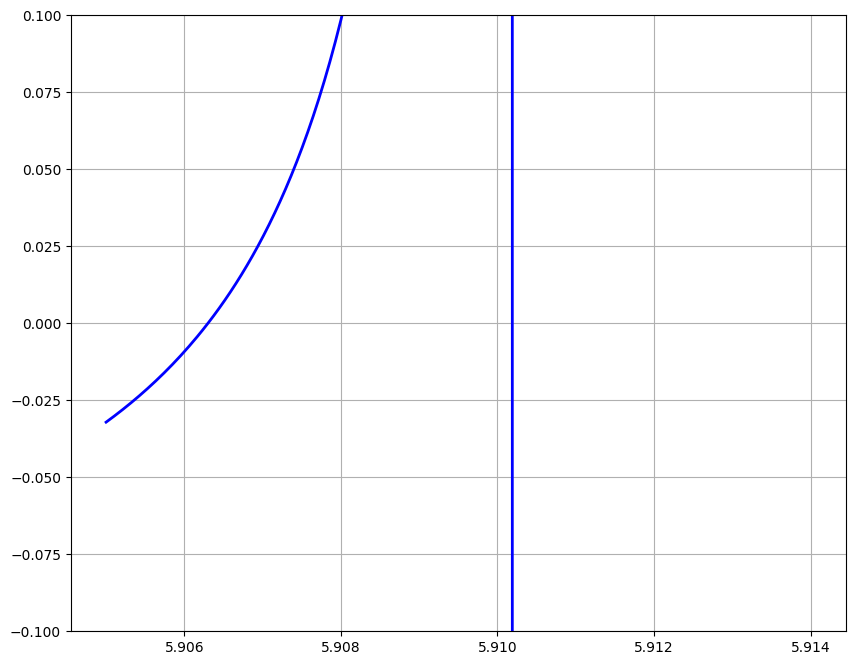

In [17]:
num_mu_range = np.linspace(5.905, 5.914, 256)
theta = 0.25
alpha = 0.426275
(fig, ax) = plot_eq_mu(numerical_problem, 
                        num_mu_range, 
                        theta, 
                        alpha, 
                        ylim = (-1e-1, 1e-1), 
                        verbose = True)

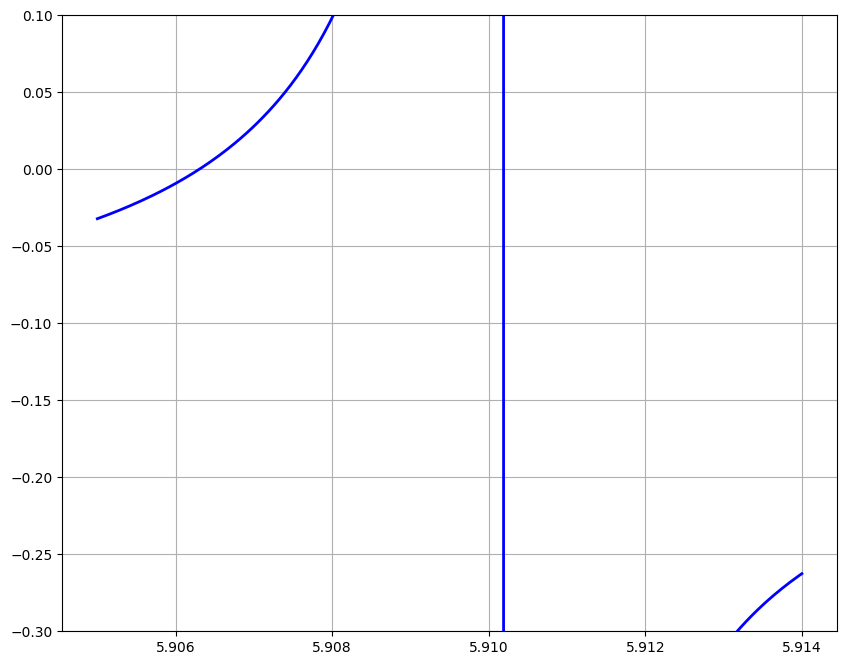

In [14]:
ax.set_ylim((-0.3, 0.1)) 
fig

[0.05       0.0518591  0.0537182  0.0555773  0.0574364  0.0592955
 0.0611546  0.0630137  0.0648728  0.0667319  0.068591   0.0704501
 0.0723092  0.0741683  0.0760274  0.0778865  0.0797456  0.0816047
 0.0834638  0.0853229  0.087182   0.0890411  0.0909002  0.0927593
 0.0946184  0.0964775  0.09833659 0.10019569 0.10205479 0.10391389
 0.10577299 0.10763209 0.10949119 0.11135029 0.11320939 0.11506849
 0.11692759 0.11878669 0.12064579 0.12250489 0.12436399 0.12622309
 0.12808219 0.12994129 0.13180039 0.13365949 0.13551859 0.13737769
 0.13923679 0.14109589 0.14295499 0.14481409 0.14667319 0.14853229
 0.15039139 0.15225049 0.15410959 0.15596869 0.15782779 0.15968689
 0.16154599 0.16340509 0.16526419 0.16712329 0.16898239 0.17084149
 0.17270059 0.17455969 0.17641879 0.17827789 0.18013699 0.18199609
 0.18385519 0.18571429 0.18757339 0.18943249 0.19129159 0.19315068
 0.19500978 0.19686888 0.19872798 0.20058708 0.20244618 0.20430528
 0.20616438 0.20802348 0.20988258 0.21174168 0.21360078 0.21545988

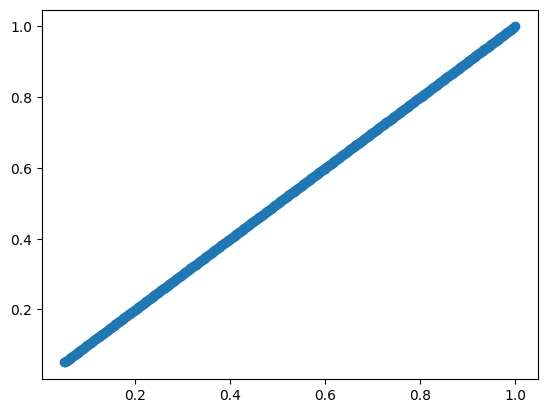

In [32]:
def plot_theta_range():
    statistics = np.loadtxt("../num_mu_statistics_alpha_range.data", unpack = True)
    theta_range = statistics[1]
    theta_range_std = np.linspace(theta_range[0], theta_range[-1], len(theta_range))
    plt.scatter(theta_range_std, theta_range)
    print(theta_range)

plot_theta_range()

Solving the following system: 


Eq(Derivative(\tilde{\delta\Psi}(z), (z, 2)), \alpha**2*sqrt(\theta**2 + 1)*exp(z*(sqrt(\theta**2 + 1) + 1))/2 + \alpha**2*exp(z*(sqrt(\theta**2 + 1) + 1))/2 - \mu**2*\tilde{\delta\Psi}(z)*exp(2*z) + \theta**2*\tilde{\delta\Psi}(z))

Eq(\epsilon**2*(-2*\mu**2*\overline{\delta{p}}^{\varpi}_{int} + 2*\mu**2*Derivative(\tilde{\delta\Psi}(z), z) - sqrt(\theta**2 + 1)*(sqrt(\theta**2 + 1) + 1) + 2) + 4*(1 - sqrt(\theta**2 + 1))*sqrt(\theta**2 + 1), 0)

Eq(\overline{\delta{p}}^{\varpi}_{int}, Integral((\alpha**2*sqrt(\theta**2 + 1)*exp(z*sqrt(\theta**2 + 1))/2 + \alpha**2*exp(z*sqrt(\theta**2 + 1))/2 - \mu**2*\tilde{\delta\Psi}(z)*exp(z))*exp(z*(sqrt(\theta**2 + 1) + 2)), (z, -oo, 0)))

theta =  3.530e-01, alpha =  1.000e+00
 10) num_mu = 5.9071e+00, partial_dPsi0[z = 0] = 9.2958e-01, dPsi[z = 0] = 0.0000e+00, dPsi[z = -inf] = 3.0958e-15, max|dPsi| = 3.7030e-01
 20) num_mu = 5.9149e+00, partial_dPsi0[z = 0] = 9.7552e-01, dPsi[z = 0] = 0.0000e+00, dPsi[z = -inf] = -4.5020e-15, max|dPsi| = 3.8681e-01
 30) num_mu = 5.9227e+00, partial_dPsi0[z = 0] = 1.0263e+00, dPsi[z = 0] = 0.0000e+00, dPsi[z = -inf] = 3.0518e-15, max|dPsi| = 4.0511e-01
 40) num_mu = 5.9306e+00, partial_dPsi0[z = 0] = 1.0827e+00, dPsi[z = 0] = 0.0000e+00, dPsi[z = -inf] = 9.0718e-16, max|dPsi| = 4.2549e-01
 50) num_mu = 5.9384e+00, partial_dPsi0[z = 0] = 1.1458e+00, dPsi[z = 0] = 0.0000e+00, dPsi[z = -inf] = -7.7728e-15, max|dPsi| = 4.4832e-01
 60) num_mu = 5.9463e+00, partial_dPsi0[z = 0] = 1.2169e+00, dPsi[z = 0] = 0.0000e+00, dPsi[z = -inf] = -4.8535e-15, max|dPsi| = 4.7407e-01
 70) num_mu = 5.9541e+00, partial_dPsi0[z = 0] = 1.2975e+00, dPsi[z = 0] = 0.0000e+00, dPsi[z = -inf] = -1.2379e-14, max|dPs

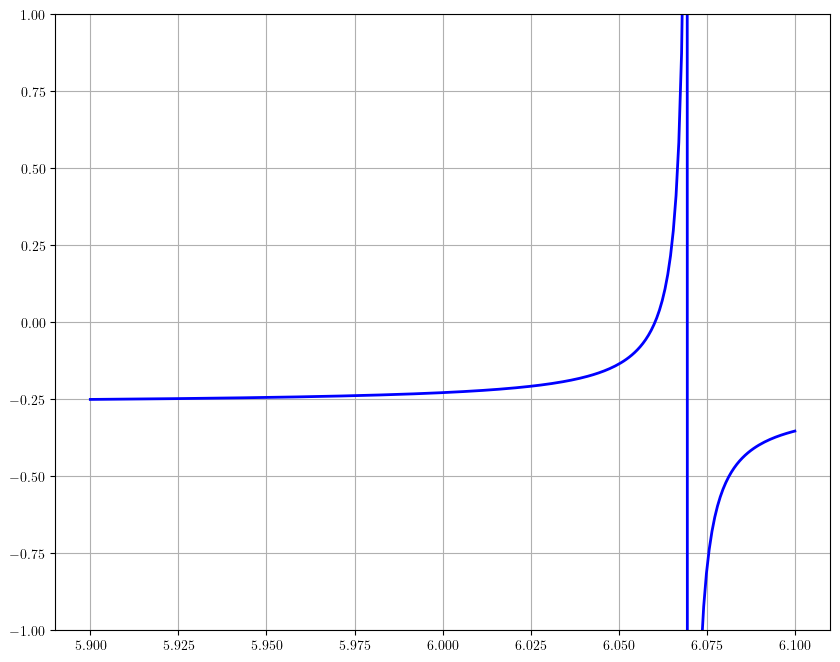

In [15]:
num_mu_arr = np.linspace(5.9, 6.1, 256)
theta = 0.35303326810176
alpha = 1
(fig, ax) = plot_eq_mu(numerical_problem, 
                            num_mu_arr, 
                            theta, 
                            alpha, 
                            ylim = (-1, 1), 
                            verbose = True)

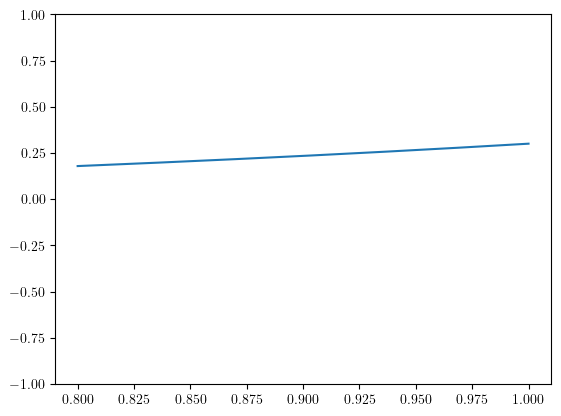

In [33]:
def plot_eq_small_theta():
    num_mu_arr = np.linspace(0.8, 1, 500)
    eq = [4 / num_mu * jv(1, num_mu) / jv(0, num_mu) - 2 for num_mu in num_mu_arr]
    plt.plot(num_mu_arr, eq)
    plt.ylim(-1, 1)

plot_eq_small_theta()

Solving the following system: 


Eq(Derivative(\tilde{\delta\Psi}(z), (z, 2)), \alpha**2*sqrt(\theta**2 + 1)*exp(z*(sqrt(\theta**2 + 1) + 1))/2 + \alpha**2*exp(z*(sqrt(\theta**2 + 1) + 1))/2 - \mu**2*\tilde{\delta\Psi}(z)*exp(2*z) + \theta**2*\tilde{\delta\Psi}(z))

Eq(\epsilon**2*(-2*\mu**2*\overline{\delta{p}}^{\varpi}_{int} + 2*\mu**2*Derivative(\tilde{\delta\Psi}(z), z) - sqrt(\theta**2 + 1)*(sqrt(\theta**2 + 1) + 1) + 2) + 4*(1 - sqrt(\theta**2 + 1))*sqrt(\theta**2 + 1), 0)

Eq(\overline{\delta{p}}^{\varpi}_{int}, Integral((\alpha**2*sqrt(\theta**2 + 1)*exp(z*sqrt(\theta**2 + 1))/2 + \alpha**2*exp(z*sqrt(\theta**2 + 1))/2 - \mu**2*\tilde{\delta\Psi}(z)*exp(z))*exp(z*(sqrt(\theta**2 + 1) + 2)), (z, -oo, 0)))

Eq(\mu, 5.36264631940102)

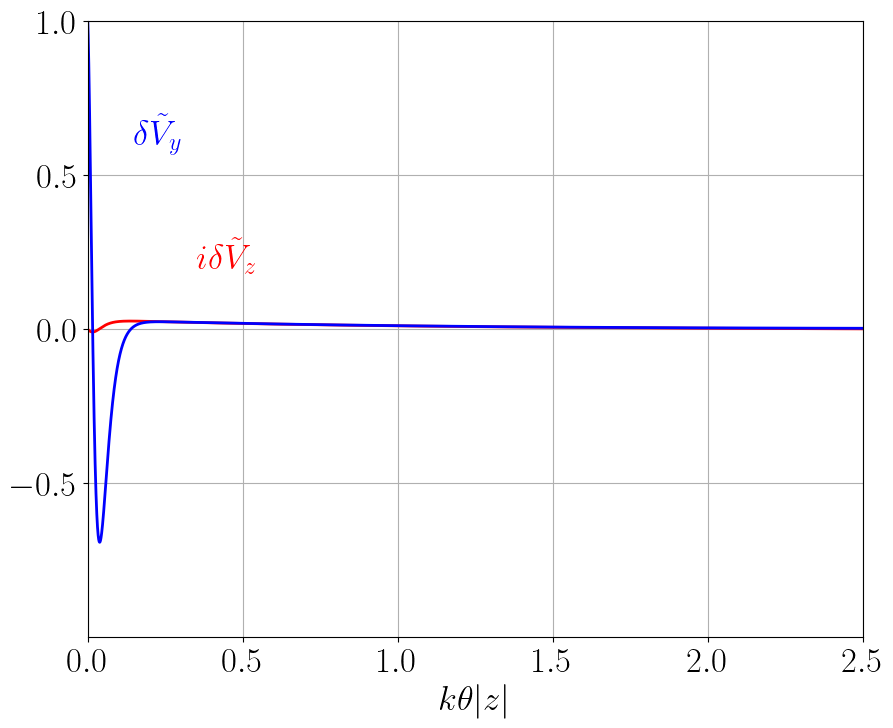

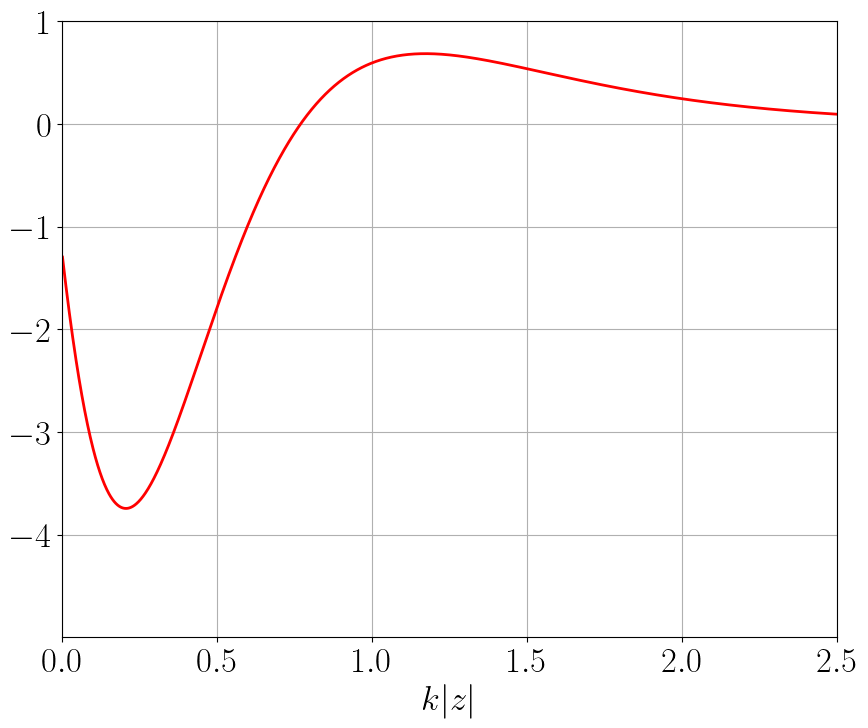

In [12]:
alpha = 1.0 
theta = 0.35303326810176 
num_mu = 6.06
numerical_solution = perform_numerical_experiment(numerical_problem, 
                                                  num_mu,
                                                  theta,
                                                  alpha,
                                                  display_result = True,
                                                  verbose = True)

In [11]:
numerical_solution

NumericalSolution(num_mu=6.060326463604154, theta=0.35303326810176, alpha=1.0, z=array([ 0.00000000e+00, -2.59339662e-04, -5.18679324e-04, ...,
       -8.49726403e+00, -8.49752337e+00, -8.49778271e+00]), dPsi=array([ 0.00000000e+00, -3.89116525e-03, -7.78225167e-03, ...,
        2.32412730e-04,  1.16206364e-04,  7.13673912e-14]), partial_dPsi0=15.004266823723416)

In [100]:
array = pickle.load(open('./test_bin.data', 'rb'))
array

[[_MetaData(num_mu=5.282197972280898, theta=0.05, alpha=1.0, partial_dPsi0=0.5803174546234515),
  _MetaData(num_mu=5.2937591879884796, theta=0.05333333333333334, alpha=1.0, partial_dPsi0=0.5903378648975651),
  _MetaData(num_mu=5.305410103051896, theta=0.056666666666666664, alpha=1.0, partial_dPsi0=0.6009569705732717),
  _MetaData(num_mu=5.317128286267576, theta=0.06, alpha=1.0, partial_dPsi0=0.6121775333336581)],
 [_MetaData(num_mu=5.2831719651192, theta=0.05, alpha=0.9866666666666667, partial_dPsi0=0.5666542404943947),
  _MetaData(num_mu=5.294828821484365, theta=0.05333333333333334, alpha=0.9866666666666667, partial_dPsi0=0.5766478531232988),
  _MetaData(num_mu=5.306573906379549, theta=0.056666666666666664, alpha=0.9866666666666667, partial_dPsi0=0.5872403310747083),
  _MetaData(num_mu=5.3183840550114985, theta=0.06, alpha=0.9866666666666667, partial_dPsi0=0.5984344414973223)]]

In [106]:
storage_test

[[_MetaData(num_mu=5.282197972280898, theta=0.05, alpha=1.0, partial_dPsi0=0.5803174546234515),
  _MetaData(num_mu=5.2937591879884796, theta=0.05333333333333334, alpha=1.0, partial_dPsi0=0.5903378648975651),
  _MetaData(num_mu=5.305410103051896, theta=0.056666666666666664, alpha=1.0, partial_dPsi0=0.6009569705732717),
  _MetaData(num_mu=5.317128286267576, theta=0.06, alpha=1.0, partial_dPsi0=0.6121775333336581)],
 [_MetaData(num_mu=5.2831719651192, theta=0.05, alpha=0.9866666666666667, partial_dPsi0=0.5666542404943947),
  _MetaData(num_mu=5.294828821484365, theta=0.05333333333333334, alpha=0.9866666666666667, partial_dPsi0=0.5766478531232988),
  _MetaData(num_mu=5.306573906379549, theta=0.056666666666666664, alpha=0.9866666666666667, partial_dPsi0=0.5872403310747083),
  _MetaData(num_mu=5.3183840550114985, theta=0.06, alpha=0.9866666666666667, partial_dPsi0=0.5984344414973223)],
 [_MetaData(num_mu=5.284180132402803, theta=0.05, alpha=0.9733333333333333, partial_dPsi0=0.5531744479829728

In [86]:
import time

try:
    for i in range(100):
        print('Sleeping')
        time.sleep(1)
        print('Waking up')
except KeyboardInterrupt:
    print(f'Ending with i = {i}')

Sleeping
Waking up
Sleeping
Waking up
Sleeping
Waking up
Sleeping
Waking up
Sleeping
Waking up
Sleeping
Waking up
Sleeping
Waking up
Sleeping
Ending with i = 7


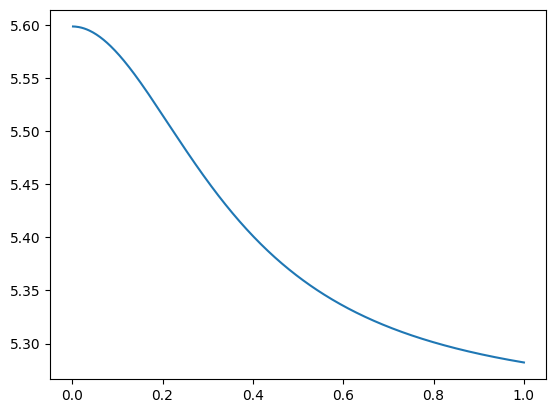

In [95]:
def plot_num_mu_alpha():
    storage = np.genfromtxt('./num_mu_statistics_theta_5e-2.data', unpack=True)
    alpha_range, num_mu_range = storage[0], storage[2]
    plt.plot(alpha_range, num_mu_range)

plot_num_mu_alpha()

In [126]:
save_dump(storage2, 'num_mu_statistics.data')

In [127]:
storage2

[[_MetaData(num_mu=5.282197972280898, theta=0.05, alpha=1.0, partial_dPsi0=0.5803174546234515),
  _MetaData(num_mu=5.288633582715978, theta=0.05185909980430529, alpha=1.0, partial_dPsi0=0.5858324619012281),
  _MetaData(num_mu=5.295100254962263, theta=0.05371819960861057, alpha=1.0, partial_dPsi0=0.5915333211105704),
  _MetaData(num_mu=5.301593993547869, theta=0.05557729941291585, alpha=1.0, partial_dPsi0=0.5974205112716324),
  _MetaData(num_mu=5.308110887805403, theta=0.057436399217221136, alpha=1.0, partial_dPsi0=0.6034945115377548),
  _MetaData(num_mu=5.3146471197006315, theta=0.05929549902152642, alpha=1.0, partial_dPsi0=0.6097558010492263),
  _MetaData(num_mu=5.321198970894901, theta=0.061154598825831706, alpha=1.0, partial_dPsi0=0.6162048587859311),
  _MetaData(num_mu=5.327762829041151, theta=0.06301369863013699, alpha=1.0, partial_dPsi0=0.6228421634189749),
  _MetaData(num_mu=5.334335193319881, theta=0.06487279843444227, alpha=1.0, partial_dPsi0=0.6296681931625526),
  _MetaData(n

In [41]:
import inspect
import contextlib

@contextlib.contextmanager
def redirect_to_tqdm():
    old_print = print
    def new_print(*args, **kwargs):
        try:
            tqdm.write(*args, **kwargs)
        except:
            old_print(*args, ** kwargs)

    try:
        inspect.builtins.print = new_print
        yield
    finally:
        inspect.builtins.print = old_print

In [47]:
def plot_eq_mu(sym_equations: tuple, numerical_parameters: NumericalParameters, 
               num_mu_arr: Iterable, *, 
               verbose: bool = False,
               ylim: tuple[float, float] | None = None) -> tuple:
    
    global sym_d2z_dPsi_dim_symbol
    
    numerical_problem = NumericalProblem(sym_equations = sym_equations, 
                                         numerical_parameters = numerical_parameters)
    numerical_problem.show_equations()
    data = numerical_problem.plot_mu_eq(num_mu_arr, ylim = ylim, verbose = verbose)
    return data


def plot_dPsi_inf(sym_equations: tuple, numerical_parameters: NumericalParameters, 
                  num_mu: float, partial_dPsi0_arr: Iterable) -> None:
    
    global sym_d2z_dPsi_dim_symbol
    
    numerical_problem = NumericalProblem(sym_equations = sym_equations, 
                                         numerical_parameters = numerical_parameters)
    numerical_problem.show_equations()
    numerical_problem.plot_dPsi_inf_partial_dPsi0(num_mu, partial_dPsi0_arr)


def perform_numerical_experiment(sym_equations: tuple, 
                                 numerical_parameters: NumericalParameters, 
                                 num_mu_initial: float, *, 
                                 display_result: bool = True, 
                                 verbose: bool = False) -> NumericalSolution:
    global sym_d2z_dPsi_dim_symbol
    
    
    numerical_problem = NumericalProblem(sym_equations = sym_equations, 
                                         numerical_parameters = numerical_parameters)
    
    numerical_problem.show_equations()
    _ = numerical_problem.solve_mu_eq_newton(num_mu_initial)
    # _ = numerical_problem.solve_mu_eq_bisec(num_mu_interval, verbose = verbose)

    numerical_problem.plot_show()
    num_mu, z, dPsi, partial_dPsi0 = numerical_problem.solution 
    
    if display_result:
        display(sym.Eq(sym_mu, num_mu, evaluate = False))

    return numerical_problem.solution

[5.67675540e+00 7.39892200e-10 4.49688757e-03]


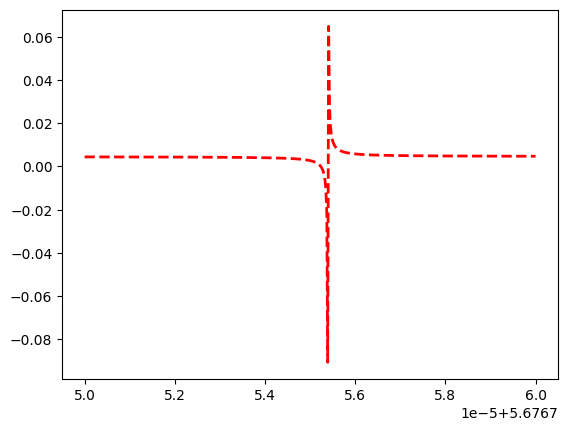

In [55]:
def fit_theoretical_func_for_mu_eq(data):
    num_mu_arr, F_arr = data
    def theoretical_func(num_mu, num_mu0, a, b) -> float:
            return a / (num_mu - num_mu0) + b
    
    parameters, _ = curve_fit(theoretical_func, num_mu_arr, F_arr, 
                              bounds = ([num_mu_arr[0], -np.inf, -np.inf], [num_mu_arr[-1], np.inf, np.inf]), 
                              maxfev = 5000)
    print(parameters)
    plt.plot(num_mu_arr, theoretical_func(num_mu_arr, *parameters), linewidth = 2.0, color = 'r', linestyle = '--')
    
fit_theoretical_func_for_mu_eq(data)

Solving the following system: 


Eq(Derivative(\tilde{\delta\Psi}(z), (z, 2)), \alpha**2*sqrt(\theta**2 + 1)*exp(z*(sqrt(\theta**2 + 1) + 1))/2 + \alpha**2*exp(z*(sqrt(\theta**2 + 1) + 1))/2 - \mu**2*\tilde{\delta\Psi}(z)*exp(2*z) + \theta**2*\tilde{\delta\Psi}(z))

Eq(\epsilon**2*(-2*\mu**2*\overline{\delta{p}}^{\varpi}_{int} + 2*\mu**2*Derivative(\tilde{\delta\Psi}(z), z) - sqrt(\theta**2 + 1)*(sqrt(\theta**2 + 1) + 1) + 2) + 4*(1 - sqrt(\theta**2 + 1))*sqrt(\theta**2 + 1), 0)

Eq(\overline{\delta{p}}^{\varpi}_{int}, Integral((\alpha**2*sqrt(\theta**2 + 1)*exp(z*sqrt(\theta**2 + 1))/2 + \alpha**2*exp(z*sqrt(\theta**2 + 1))/2 - \mu**2*\tilde{\delta\Psi}(z)*exp(z))*exp(z*(sqrt(\theta**2 + 1) + 2)), (z, -oo, 0)))

Calling mu equation with mu = 5.830e+00
Calling mu equation with mu = 5.831e+00
Calling mu equation with mu = 5.831e+00
Calling mu equation with mu = 5.831e+00
Calling mu equation with mu = 5.831e+00
Calling mu equation with mu = 5.831e+00
Calling mu equation with mu = 5.831e+00
Calling mu equation with mu = 5.831e+00
Calling mu equation with mu = 5.831e+00
Calling mu equation with mu = 5.831e+00


Eq(\mu, 5.83112636302933)

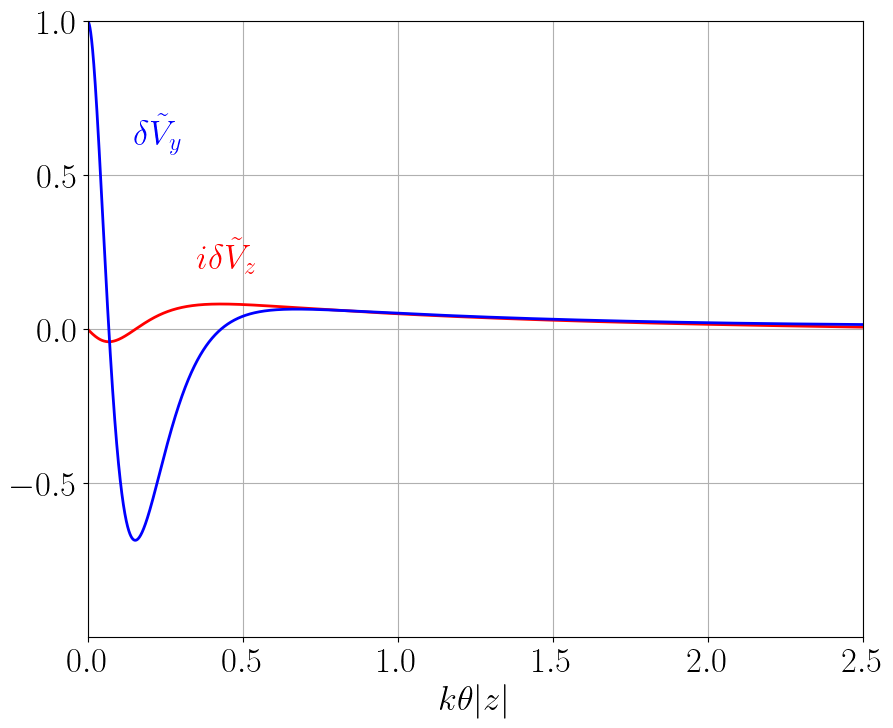

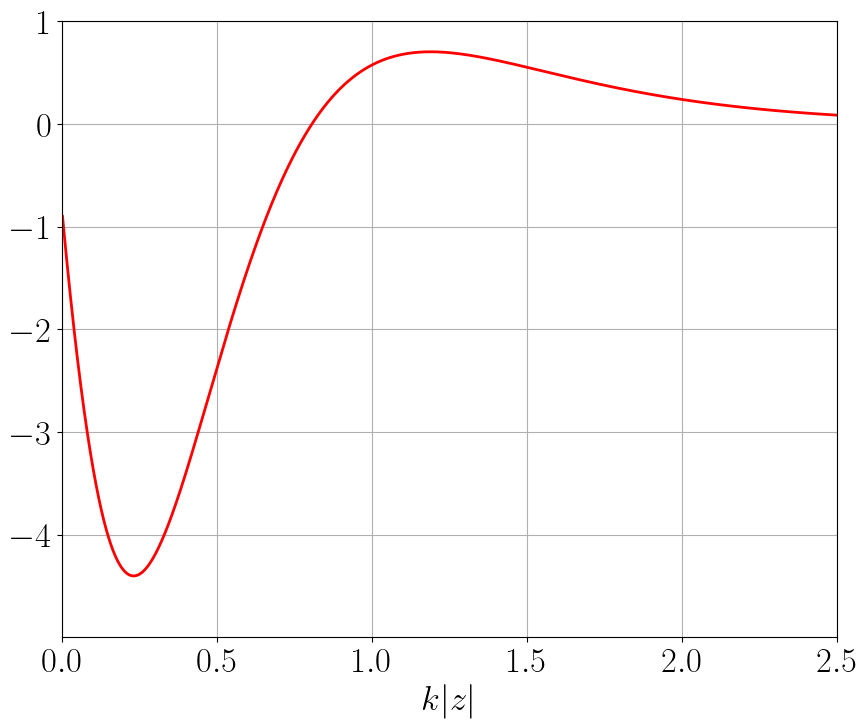

In [53]:
numerical_parameters = NumericalParameters(h0 = 1e-2, theta = 0.2, epsilon = 1e-1, alpha = 1e-1)
num_mu_initial = 5.83
numerical_solution = perform_numerical_experiment(sym_equations, 
                                                  numerical_parameters, 
                                                  num_mu_initial,
                                                  verbose = True)

In [138]:
numerical_solution.partial_dPsi0

(0.5031580176625683+0j)

In [ ]:
4.56055374828247

Solving the following system: 


Eq(Derivative(\tilde{\delta\Psi}(z), (z, 2)), \alpha**3*exp(2*z) - \mu**2*\tilde{\delta\Psi}(z)*exp(2*z) + \theta**2*\tilde{\delta\Psi}(z))

Eq(\overline{\delta{p}}^{\varpi}_{int} - Derivative(\tilde{\delta\Psi}(z), z), 0)

Eq(\overline{\delta{p}}^{\varpi}_{int}, Integral((\alpha**3 - \mu**2*\tilde{\delta\Psi}(z))*exp(4*z), (z, -oo, 0)))

Initial guesses ((55) from POF):
 	num_mu_initial = 2.4,
 	partial_dPsi0_initial = (86.41459429394827+0j),



Eq(\mu, 3.38845627635715)

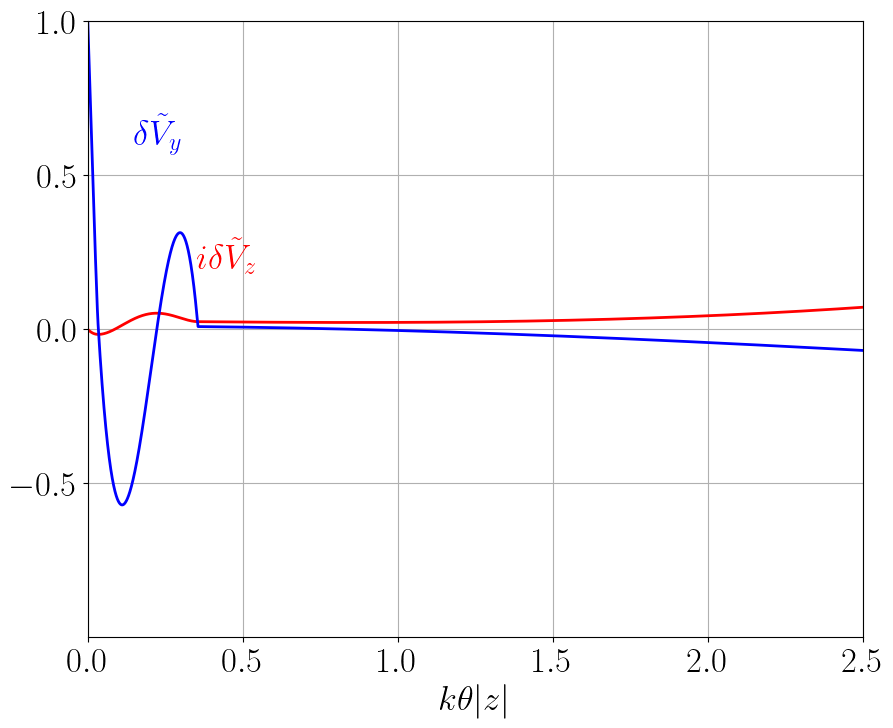

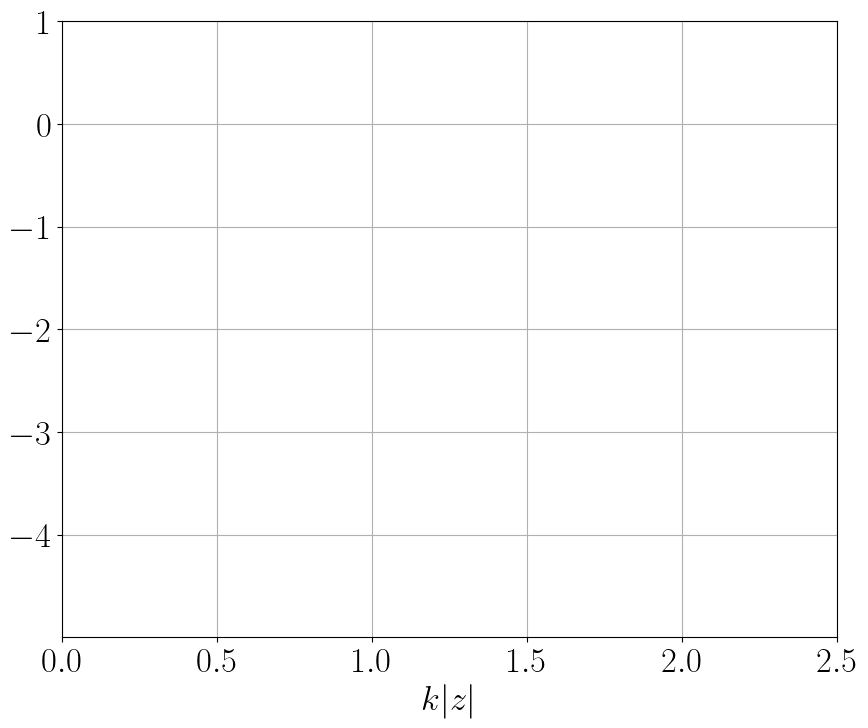

In [13]:
_ = perform_numerical_experiment(sym_equations_refactored, numerical_parameters, verbose = True)